In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.1+cu101:
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 46.9MB/s 


In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d sdfhbdskjgkndfkjw/mitbih2dimgdataset
!unzip -q /content/mitbih2dimgdataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mitbih2dimgdataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace RealDataSet/test/A/100_13.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


**Dataset 1** - https://www.kaggle.com/sdfhbdskjgkndfkjw/mitbih2dimgdataset?

Structure explained

N (Normal beat) 	90.589

S (Supraventricular ectopic beat) 	2.779

V (Ventricular ectopic beat) 	7.236

F (Fusion beat) 	803

Q (Unknown beat) 	8.038

In [ ]:
!kaggle datasets download -d analiviafr/ecg-images
!unzip -q /content/ecg-images.zip

 99% 161M/162M [00:05<00:00, 28.8MB/s]
100% 162M/162M [00:05<00:00, 33.2MB/s]


In [ ]:
!mv /content/xrays/normal /content

## Looking at the data 浏览一下数据

In [ ]:
path = Path("/content/RealDataSet/test")
path.ls() # output >>> ['test', 'labels.txt', 'train']

tfms = get_transforms(do_flip=True)

data = ImageList.from_folder(path) .random_split_by_pct() .label_from_folder() .transform(tfms,
                                                                                          size=224) .databunch()
data.normalize()


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


ImageDataBunch;

Train: LabelList (3548 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
P,P,P,P,P
Path: /content/RealDataSet/test;

Valid: LabelList (887 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
V,L,R,A,L
Path: /content/RealDataSet/test;

Test: None

In [ ]:
fnames = get_image_files('/content/RealDataSet/test/A')
fnames[:5]

[PosixPath('/content/RealDataSet/test/A/209_618.png'),
 PosixPath('/content/RealDataSet/test/A/209_444.png'),
 PosixPath('/content/RealDataSet/test/A/101_33.png'),
 PosixPath('/content/RealDataSet/test/A/222_1036.png'),
 PosixPath('/content/RealDataSet/test/A/232_1980.png')]

In [ ]:
np.random.seed(2)
#pat = r'/([^/]+)_\d+.jpg$'

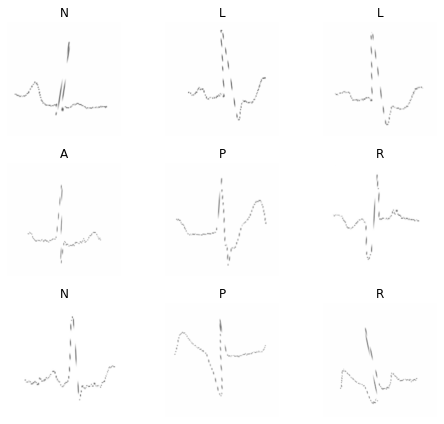

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['A', 'L', 'N', 'P', 'R', 'V']


(6, 6)

## Training: resnet34    

## 训练：resnet34

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.722401,1.031719,0.333709,00:26
1,1.221602,0.576837,0.205186,00:26
2,0.917962,0.515557,0.191657,00:26
3,0.786666,0.492674,0.180383,00:26


In [ ]:
learn.save('stage-1')

## Results 结果

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

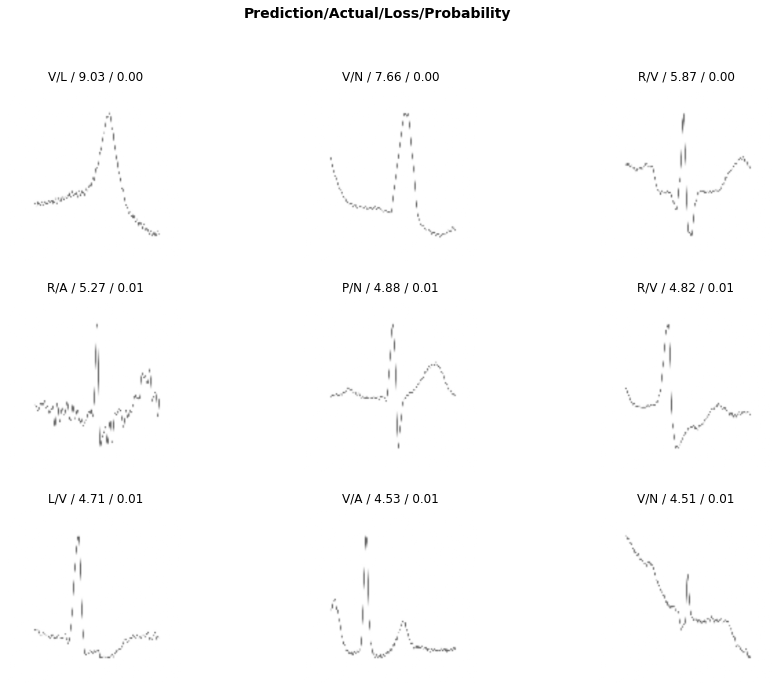

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

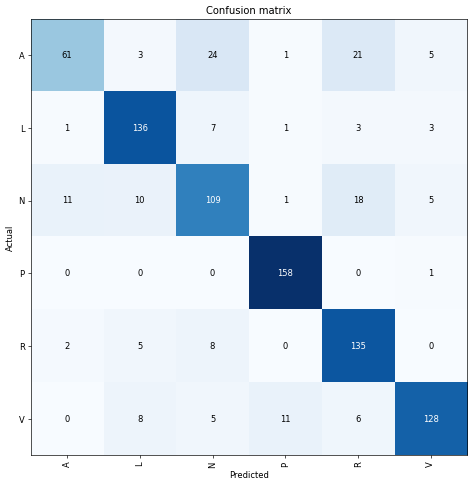

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('A', 'N', 24),
 ('A', 'R', 21),
 ('N', 'R', 18),
 ('N', 'A', 11),
 ('V', 'P', 11),
 ('N', 'L', 10),
 ('R', 'N', 8),
 ('V', 'L', 8),
 ('L', 'N', 7),
 ('V', 'R', 6),
 ('A', 'V', 5),
 ('N', 'V', 5),
 ('R', 'L', 5),
 ('V', 'N', 5)]

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.574392,0.305759,0.101466,00:27


In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


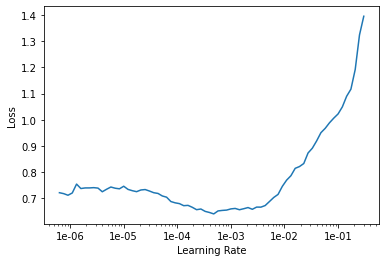

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.629510,0.431008,0.149944,00:27
1,0.377159,0.177233,0.063134,00:27


## 训练:resnet50

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


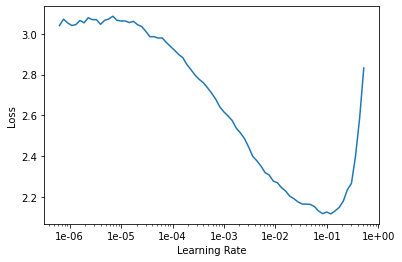

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-2,1e-1))

In [ ]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.753184,1.126856,0.359639,00:30
1,1.393003,0.909211,0.263811,00:30
2,1.075899,0.598037,0.218715,00:31
3,0.840348,0.493648,0.177001,00:30
4,0.719299,0.437777,0.158963,00:31
5,0.625373,0.394732,0.140924,00:31
6,0.566256,0.357119,0.126268,00:31
7,0.517748,0.357846,0.130778,00:31


In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.959700,2278.824463,0.820744,00:38
1,1.690500,14.076608,0.717024,00:38
2,1.139646,0.635438,0.210823,00:38


In [ ]:
learn.save('stage-2-50')

In [ ]:
learn.load('stage-1-50');

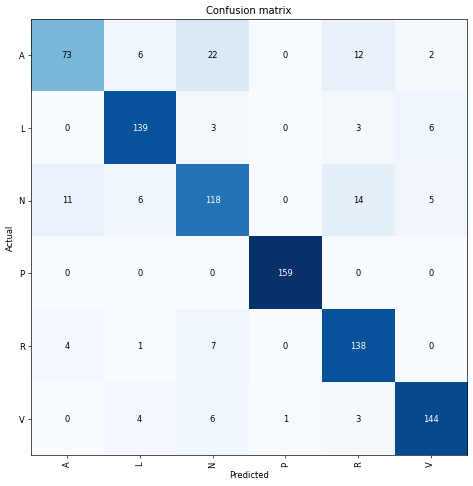

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('A', 'N', 22),
 ('N', 'R', 14),
 ('A', 'R', 12),
 ('N', 'A', 11),
 ('R', 'N', 7),
 ('A', 'L', 6),
 ('L', 'V', 6),
 ('N', 'L', 6),
 ('V', 'N', 6),
 ('N', 'V', 5),
 ('R', 'A', 4),
 ('V', 'L', 4),
 ('L', 'N', 3),
 ('L', 'R', 3),
 ('V', 'R', 3),
 ('A', 'V', 2)]